In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import decode_image
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np

In [58]:
class ConvICNN(nn.Module):
    def __init__(self, linear_layers=4, convex_layers=5, downscale=[(2048, 128), (128, 64), (64, 32), (32, 1)], beta=1e-6):
        super().__init__()
        self.beta = beta
        self.linear_layers = linear_layers
        self.convex_layers = convex_layers
        self.downscale = downscale

        # Linear block
        # Here we use either identity activation or average pooling
        self.conv_direct = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, padding=1))
        self.conv_sqr = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, padding=1))
        for i in range(linear_layers - 1):
            self.conv_direct.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))
            self.conv_sqr.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))

        # Convexity-preserving layers
        self.convex = nn.Sequential()
        for i in range(convex_layers):
            self.convex.append(nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1))#, padding=1, offset=1))
            self.convex.append(nn.CELU())

        self.linear = nn.Sequential()
        for i in range(len(downscale) - 1):
            self.linear.append(nn.Linear(downscale[i][0], downscale[i][1]))
            self.linear.append(nn.CELU())
        self.linear.append(nn.Linear(downscale[-1][0], downscale[-1][1]))


    def forward(self, x):
        x_input = x
        linear = self.conv_direct(x)
        linear += torch.square(self.conv_sqr(x))
        out = self.convex(linear)
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        strong_convexity = (self.beta / 2) * torch.sum(torch.square(x.reshape(x.size(0), -1)), dim=1, keepdim=True)
        return out + strong_convexity

    def update_weights(self):
        for i in range(0, self.convex_layers):
            # each Conv2d
            self.convex[i*2].weight.data = self.convex[i*2].weight.clamp_(min=0)

        for i in range(0, len(self.downscale)):
            # each Linear
            self.linear[i*2].weight.data = self.linear[i*2].weight.clamp_(min=0)

    def gradient(self, x):
        """Compute gradient of the network w.r.t. input"""
        if not x.requires_grad:
            x = x.clone().requires_grad_(True)
        y = self.forward(x)
        grad = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True,
            retain_graph=True
        )[0]
        return grad#.detach()

In [73]:
class W2GNLoss:
    """
    Wasserstein-2 Generative Network Loss
    """
    def __init__(self, psi_theta, psi_omega, lambda_cycle=1.0, devices=['cuda'], compute_extra_reg=False):
        self.lambda_cycle = lambda_cycle
        self.devices = devices
        self.dev0 = devices[0]
        self.dev1 = devices[1] if len(devices) > 1 else devices[0]
        self.compute_extra_reg = compute_extra_reg

        # Initialize primal and dual potentials
        self.psi_theta = psi_theta.to(self.dev0)
        self.psi_omega = psi_omega.to(self.dev1)

    def theta_device(self):
        return self.dev0

    def omega_device(self):
        return self.dev1

    def to_theta(self, t: torch.Tensor):
        """
        Transfer tensor to psi_theta device
        """
        if self.dev0 != self.dev1:
            return t.to(self.dev1, non_blocking=True)
        else:
            return t

    def to_omega(self, t: torch.Tensor):
        """
        Transfer tensor to psi_omega device
        """
        if self.dev0 != self.dev1:
            return t.to(self.dev0, non_blocking=True)
        else:
            return t

    def compute_correlations(self, X, Y, grad_psi_omega):
        """
        Compute Monte-Carlo estimate of correlations
        L_Corr = (1/K) * [sum psi_theta(x) + sum(<grad_psi_omega(y), y> - psi_theta(grad_psi_omega(y)))]
        """
        batch_size = X.shape[0]

        # Term 1: E_P[psi_theta(x)]
        term1 = self.psi_theta(X).mean()

        # Term 2: E_Q[<grad_psi_omega(y), y> - psi_theta(grad_psi_omega(y))]
        # Compute gradient of conjugate potential

        # Inner product <grad_psi_omega(y), y>
        inner_prod = torch.sum(grad_psi_omega * self.to_omega(Y), dim=(1, 2, 3), keepdim=True)

        # Evaluate primal potential at gradient
        psi_at_grad = self.psi_theta(self.to_theta(grad_psi_omega))

        term2 = (self.to_theta(inner_prod) - psi_at_grad).mean()

        return term1 + term2 # THETA

    def compute_cycle_consistency(self, Y, grad_psi_omega):
        """
        Compute cycle consistency regularization
        R_Y = E_Q[||grad_psi_theta(grad_psi_omega(y)) - y||^2]
        """
        # Forward: omega -> theta
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(grad_psi_omega))

        # Compute squared difference
        diff = grad_psi_theta - self.to_theta(Y)
        cycle_loss = torch.mean(torch.sum(diff ** 2, dim=(1, 2, 3)))

        return cycle_loss # THETA

    def compute_extra_R(self, X):
        """
        Compute extra regularization term
        R_X = (1/K) * [sum ||grad_psi_omega(grad_psi_theta(x)) - x||^2]
        """
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(X))
        grad_psi_omega = self.psi_omega.gradient(self.to_omega(grad_psi_theta))

        # Compute squared difference
        diff = grad_psi_omega - self.to_omega(X)
        r_reg = torch.mean(torch.sum(diff ** 2, dim=(1, 2, 3)))
        return r_reg

    def compute_loss(self, X, Y):
        """
        Compute loss and calculate gradients. It is optimal to store X at device 0 and Y at device 1
        Args:
            X: batch from source distribution P
            Y: batch from target distribution Q
        """
        # Step 2: Compute correlations
        grad_psi_omega = self.psi_omega.gradient(self.to_omega(Y)).detach() # heuristic from Appendix C.1
        loss_corr = self.compute_correlations(X, Y, grad_psi_omega)

        # Step 3: Compute cycle consistency
        loss_cycle = self.compute_cycle_consistency(Y, grad_psi_omega)

        # Step 4: Total loss
        if self.compute_extra_reg:
            loss_R = self.compute_extra_R(X)
            loss_R_item = loss_R.item()
            loss_total = loss_corr + (self.lambda_cycle / 2) * loss_cycle + loss_R
        else:
            loss_R = None
            loss_total = loss_corr + (self.lambda_cycle / 2) * loss_cycle

        # Step 5: Gradient step
        loss_total.backward()

        # Clamp weights in convexity-preserving layers to be non-negative
        with torch.no_grad():
            self.psi_theta.update_weights()
            self.psi_omega.update_weights()

        return {
            'loss_corr': loss_corr.item(),
            'loss_cycle': loss_cycle.item(),
            'loss_total': loss_total.item(),
            'loss_R': loss_R_item
        }

    def generate(self, X):
        """Generate samples: g(x) = grad_psi_theta(x)"""
        return self.psi_theta.gradient(X).detach()

    def inverse(self, Y):
        """Inverse mapping: g^{-1}(y) = grad_psi_omega(y)"""
        return self.psi_omega.gradient(Y).detach()

In [55]:
class W2GNTrainer:
    def __init__(self, loss_c, lr=1e-3):
        self.loss_c = loss_c
        self.optimizer = torch.optim.Adam(
           list(self.loss_c.psi_theta.parameters()) +
           list(self.loss_c.psi_omega.parameters()),
           lr=lr
        )

        self.history = {'loss_corr': [], 'loss_cycle': [], 'loss_total': [], 'loss_R': []}

    def step(self, X, Y):
        self.optimizer.zero_grad()
        losses = self.loss_c.compute_loss(X, Y)
        self.optimizer.step()

        for x in losses.keys():
            if losses[x] is not None:
                self.history[x].append(losses[x])

        return losses

    def generate(self, X):
        """Generate samples: g(x) = grad_psi_theta(x)"""
        #with torch.no_grad():
        return self.loss_c.psi_theta.gradient(X)

    def inverse(self, Y):
        """Inverse mapping: g^{-1}(y) = grad_psi_omega(y)"""
        #with torch.no_grad():
        return self.loss_c.psi_omega.gradient(Y)

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/summer2winter-yosemite")

Using Colab cache for faster access to the 'summer2winter-yosemite' dataset.


In [22]:
class S2WDataset(torch.utils.data.Dataset):
    def __init__(self, root, target_shape, is_A, is_val=False):
        super().__init__()
        self.root = root
        self.target_shape = target_shape
        self.is_val = is_val
        if is_A:
            self.train = "trainA"
            self.test = "testA"
        else:
            self.train = "trainB"
            self.test = "testB"

        if not is_val:
            #self.df = pd.read_csv(os.path.join(root, "metadata.csv"))
            self.images = os.listdir(os.path.join(root, self.train))
        else:
            self.images = os.listdir(os.path.join(root, self.test))

        self.pics = len(self.images)

    def __len__(self):
        return self.pics

    def get(self, idx, pic_dir):
        img_path = os.path.join(self.root, pic_dir, self.images[idx])

        # Load the image
        img = Image.open(img_path).resize((self.target_shape, self.target_shape))

        return np.asarray(img, dtype=np.float32) / 128.0 - 1.0, {}

    def get_train(self, idx):
        return self.get(idx, self.train)

    def get_val(self, idx):
        return self.get(idx, self.test)

    def __getitem__(self, idx):
        if self.is_val:
            return self.get_val(idx)
        return self.get_train(idx)

In [74]:
batch_size = 16
datasetA = S2WDataset(path, 128, is_A=True)
datasetB = S2WDataset(path, 128, is_A=False)
pics = min(len(datasetA), len(datasetB))
datasetA.pics = pics
datasetB.pics = pics

datasetVal = S2WDataset(path, 128, is_A=True, is_val=True)

dataloaderA = torch.utils.data.DataLoader(
    datasetA,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

dataloaderB = torch.utils.data.DataLoader(
    datasetB,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

dataVal = torch.utils.data.DataLoader(
    datasetVal,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

Epoch 1/30:   2%|▏         | 1/61 [00:04<04:03,  4.05s/it]


Epoch 0: Corr=0.0249, Cycle=16756.6504, Reg=15967.7148, Total=293257344.0000


Epoch 1/30:   3%|▎         | 2/61 [00:07<03:54,  3.98s/it]


Epoch 0: Corr=-77201.0391, Cycle=581652.5000, Reg=1076619.7500, Total=10179917824.0000


Epoch 1/30:   5%|▍         | 3/61 [00:11<03:50,  3.98s/it]


Epoch 0: Corr=-43954.3320, Cycle=245600.5469, Reg=284916.7500, Total=4298250240.0000


Epoch 1/30:   7%|▋         | 4/61 [00:16<03:48,  4.00s/it]


Epoch 0: Corr=34165.2734, Cycle=14627.0723, Reg=216001.3438, Total=256223920.0000


Epoch 1/30:   8%|▊         | 5/61 [00:20<03:46,  4.04s/it]


Epoch 0: Corr=38291.5820, Cycle=15386.5684, Reg=18964.0352, Total=269322240.0000


Epoch 1/30:  10%|▉         | 6/61 [00:24<03:43,  4.07s/it]


Epoch 0: Corr=54063.6562, Cycle=13965.6094, Reg=15930.0059, Total=244468160.0000


Epoch 1/30:  11%|█▏        | 7/61 [00:28<03:40,  4.09s/it]


Epoch 0: Corr=57132.5625, Cycle=14046.8594, Reg=14430.8115, Total=245891600.0000


Epoch 1/30:  13%|█▎        | 8/61 [00:32<03:36,  4.09s/it]


Epoch 0: Corr=73334.4844, Cycle=16027.9141, Reg=14085.2969, Total=280575936.0000


Epoch 1/30:  15%|█▍        | 9/61 [00:36<03:32,  4.08s/it]


Epoch 0: Corr=77687.4141, Cycle=15216.3535, Reg=17861.4395, Total=266381728.0000


Epoch 1/30:  16%|█▋        | 10/61 [00:40<03:26,  4.06s/it]


Epoch 0: Corr=78669.2500, Cycle=13568.1328, Reg=17589.1777, Total=237538576.0000


Epoch 1/30:  18%|█▊        | 11/61 [00:44<03:21,  4.02s/it]


Epoch 0: Corr=81187.8750, Cycle=14485.9385, Reg=14805.6738, Total=253599904.0000


Epoch 1/30:  20%|█▉        | 12/61 [00:48<03:15,  4.00s/it]


Epoch 0: Corr=101980.7656, Cycle=13403.3691, Reg=15895.0605, Total=234676832.0000


Epoch 1/30:  21%|██▏       | 13/61 [00:52<03:10,  3.97s/it]


Epoch 0: Corr=99643.2344, Cycle=14011.1699, Reg=14570.6641, Total=245309696.0000


Epoch 1/30:  23%|██▎       | 14/61 [00:56<03:05,  3.95s/it]


Epoch 0: Corr=85397.8359, Cycle=15704.5566, Reg=13857.4980, Total=274928992.0000


Epoch 1/30:  25%|██▍       | 15/61 [01:00<03:01,  3.94s/it]


Epoch 0: Corr=110226.3906, Cycle=16675.5781, Reg=13756.0000, Total=291946624.0000


Epoch 1/30:  26%|██▌       | 16/61 [01:04<02:56,  3.92s/it]


Epoch 0: Corr=90035.7344, Cycle=12395.8066, Reg=14006.7119, Total=217030656.0000


Epoch 1/30:  28%|██▊       | 17/61 [01:07<02:51,  3.91s/it]


Epoch 0: Corr=115574.0078, Cycle=35861.3711, Reg=16549.9238, Total=627706176.0000


Epoch 1/30:  30%|██▉       | 18/61 [01:11<02:47,  3.90s/it]


Epoch 0: Corr=150158.0938, Cycle=14059.9766, Reg=15344.4961, Total=246215088.0000


Epoch 1/30:  31%|███       | 19/61 [01:15<02:43,  3.89s/it]


Epoch 0: Corr=134142.5312, Cycle=16891.9316, Reg=11818.5449, Total=295754752.0000


Epoch 1/30:  33%|███▎      | 20/61 [01:19<02:39,  3.89s/it]


Epoch 0: Corr=135522.2500, Cycle=14244.0156, Reg=14466.3887, Total=249420256.0000


Epoch 1/30:  34%|███▍      | 21/61 [01:23<02:35,  3.89s/it]


Epoch 0: Corr=162956.6562, Cycle=14008.1035, Reg=16643.4062, Total=245321408.0000


Epoch 1/30:  36%|███▌      | 22/61 [01:27<02:31,  3.89s/it]


Epoch 0: Corr=216154.0469, Cycle=3043866.2500, Reg=18860.8125, Total=53267898368.0000


Epoch 1/30:  38%|███▊      | 23/61 [01:31<02:28,  3.90s/it]


Epoch 0: Corr=122055.0547, Cycle=16417.1621, Reg=13571.8242, Total=287435968.0000


Epoch 1/30:  39%|███▉      | 24/61 [01:35<02:24,  3.91s/it]


Epoch 0: Corr=146101.6250, Cycle=16270.0127, Reg=15263.4971, Total=284886592.0000


Epoch 1/30:  41%|████      | 25/61 [01:39<02:21,  3.92s/it]


Epoch 0: Corr=120680.5312, Cycle=16079.1602, Reg=13747.5625, Total=281519744.0000


Epoch 1/30:  43%|████▎     | 26/61 [01:43<02:17,  3.93s/it]


Epoch 0: Corr=95656.0156, Cycle=16832.9141, Reg=12558.3818, Total=294684192.0000


Epoch 1/30:  44%|████▍     | 27/61 [01:47<02:14,  3.94s/it]


Epoch 0: Corr=127583.7266, Cycle=15134.6699, Reg=17283.2773, Total=265001584.0000


Epoch 1/30:  46%|████▌     | 28/61 [01:51<02:10,  3.95s/it]


Epoch 0: Corr=115021.2422, Cycle=14316.0156, Reg=17805.6016, Total=250663104.0000


Epoch 1/30:  48%|████▊     | 29/61 [01:54<02:06,  3.96s/it]


Epoch 0: Corr=109893.1875, Cycle=15591.5449, Reg=16115.8418, Total=272978048.0000


Epoch 1/30:  49%|████▉     | 30/61 [01:58<02:02,  3.96s/it]


Epoch 0: Corr=84535.7188, Cycle=16381.1289, Reg=14510.5205, Total=286768800.0000


Epoch 1/30:  51%|█████     | 31/61 [02:02<01:58,  3.96s/it]


Epoch 0: Corr=82940.8438, Cycle=18871.4492, Reg=15893.5498, Total=330349216.0000


Epoch 1/30:  52%|█████▏    | 32/61 [02:06<01:54,  3.96s/it]


Epoch 0: Corr=100349.3906, Cycle=15963.0488, Reg=16557.6133, Total=279470240.0000


Epoch 1/30:  54%|█████▍    | 33/61 [02:10<01:50,  3.96s/it]


Epoch 0: Corr=78353.0312, Cycle=18094.4023, Reg=14007.0508, Total=316744416.0000


Epoch 1/30:  56%|█████▌    | 34/61 [02:14<01:46,  3.96s/it]


Epoch 0: Corr=78854.3359, Cycle=16430.7402, Reg=15411.3398, Total=287632224.0000


Epoch 1/30:  57%|█████▋    | 35/61 [02:18<01:42,  3.96s/it]


Epoch 0: Corr=74913.4141, Cycle=16668.0137, Reg=16330.3545, Total=291781472.0000


Epoch 1/30:  59%|█████▉    | 36/61 [02:22<01:38,  3.95s/it]


Epoch 0: Corr=77677.8125, Cycle=15808.7979, Reg=16275.5723, Total=276747904.0000


Epoch 1/30:  61%|██████    | 37/61 [02:26<01:34,  3.95s/it]


Epoch 0: Corr=73678.9766, Cycle=15004.7383, Reg=14570.9531, Total=262671168.0000


Epoch 1/30:  62%|██████▏   | 38/61 [02:30<01:30,  3.95s/it]


Epoch 0: Corr=73802.8594, Cycle=16709.0879, Reg=18189.8613, Total=292500992.0000


Epoch 1/30:  64%|██████▍   | 39/61 [02:34<01:26,  3.93s/it]


Epoch 0: Corr=81495.6641, Cycle=16050.0117, Reg=15726.9551, Total=280972416.0000


Epoch 1/30:  66%|██████▌   | 40/61 [02:38<01:22,  3.93s/it]


Epoch 0: Corr=66295.9688, Cycle=16498.2910, Reg=15813.1631, Total=288802208.0000


Epoch 1/30:  67%|██████▋   | 41/61 [02:42<01:18,  3.92s/it]


Epoch 0: Corr=62493.3711, Cycle=14469.7539, Reg=15287.7041, Total=253298464.0000


Epoch 1/30:  69%|██████▉   | 42/61 [02:46<01:14,  3.92s/it]


Epoch 0: Corr=81532.9531, Cycle=13149.3984, Reg=14272.5029, Total=230210288.0000


Epoch 1/30:  70%|███████   | 43/61 [02:50<01:10,  3.92s/it]


Epoch 0: Corr=55724.3828, Cycle=14207.2422, Reg=15713.6582, Total=248698176.0000


Epoch 1/30:  72%|███████▏  | 44/61 [02:54<01:06,  3.92s/it]


Epoch 0: Corr=85119.2656, Cycle=12737.4336, Reg=18124.1094, Total=223008336.0000


Epoch 1/30:  74%|███████▍  | 45/61 [02:57<01:02,  3.92s/it]


Epoch 0: Corr=57150.6953, Cycle=16048.0400, Reg=13795.6104, Total=280911648.0000


Epoch 1/30:  75%|███████▌  | 46/61 [03:01<00:58,  3.92s/it]


Epoch 0: Corr=78588.5625, Cycle=16095.2764, Reg=15767.1484, Total=281761696.0000


Epoch 1/30:  77%|███████▋  | 47/61 [03:05<00:54,  3.92s/it]


Epoch 0: Corr=74927.5312, Cycle=16096.0566, Reg=16122.5605, Total=281772032.0000


Epoch 1/30:  79%|███████▊  | 48/61 [03:09<00:51,  3.93s/it]


Epoch 0: Corr=79858.5547, Cycle=15034.5771, Reg=14111.8672, Total=263199072.0000


Epoch 1/30:  80%|████████  | 49/61 [03:13<00:47,  3.94s/it]


Epoch 0: Corr=83749.8125, Cycle=15345.2793, Reg=17060.0117, Total=268643200.0000


Epoch 1/30:  82%|████████▏ | 50/61 [03:17<00:43,  3.93s/it]


Epoch 0: Corr=60902.2578, Cycle=15637.6582, Reg=13938.6631, Total=273733856.0000


Epoch 1/30:  84%|████████▎ | 51/61 [03:21<00:39,  3.93s/it]


Epoch 0: Corr=84293.0703, Cycle=16061.7666, Reg=14049.5645, Total=281179264.0000


Epoch 1/30:  85%|████████▌ | 52/61 [03:25<00:35,  3.94s/it]


Epoch 0: Corr=67271.0312, Cycle=15869.8262, Reg=16639.6016, Total=277805856.0000


Epoch 1/30:  87%|████████▋ | 53/61 [03:29<00:31,  3.94s/it]


Epoch 0: Corr=75560.3594, Cycle=15362.6943, Reg=15041.0615, Total=268937728.0000


Epoch 1/30:  89%|████████▊ | 54/61 [03:33<00:27,  3.95s/it]


Epoch 0: Corr=81284.5938, Cycle=12931.7314, Reg=18124.6035, Total=226404704.0000


Epoch 1/30:  90%|█████████ | 55/61 [03:37<00:23,  3.95s/it]


Epoch 0: Corr=94980.5000, Cycle=15631.1240, Reg=16918.4844, Total=273656576.0000


Epoch 1/30:  92%|█████████▏| 56/61 [03:41<00:19,  3.95s/it]


Epoch 0: Corr=49923.0195, Cycle=15864.4180, Reg=16800.5957, Total=277694048.0000


Epoch 1/30:  93%|█████████▎| 57/61 [03:45<00:15,  3.95s/it]


Epoch 0: Corr=68462.4141, Cycle=13841.9971, Reg=14019.7881, Total=242317424.0000


Epoch 1/30:  95%|█████████▌| 58/61 [03:49<00:11,  3.94s/it]


Epoch 0: Corr=87461.0391, Cycle=14749.6426, Reg=13498.2324, Total=258219712.0000


Epoch 1/30:  97%|█████████▋| 59/61 [03:53<00:07,  3.94s/it]


Epoch 0: Corr=76453.4297, Cycle=14918.3838, Reg=14771.4492, Total=261162928.0000


Epoch 1/30:  98%|█████████▊| 60/61 [03:57<00:03,  3.94s/it]


Epoch 0: Corr=71038.9609, Cycle=16103.3643, Reg=15171.2510, Total=281895072.0000



Epoch 0: Corr=135204.9688, Cycle=18886.6250, Reg=9203.3086, Total=330660352.0000


Epoch 2/30:   2%|▏         | 1/61 [00:03<03:58,  3.97s/it]


Epoch 1: Corr=83406.7812, Cycle=14132.3623, Reg=16928.6738, Total=247416672.0000


Epoch 2/30:   3%|▎         | 2/61 [00:07<03:53,  3.95s/it]


Epoch 1: Corr=48714.9219, Cycle=17611.9609, Reg=14469.0117, Total=308272480.0000


Epoch 2/30:   5%|▍         | 3/61 [00:11<03:48,  3.94s/it]


Epoch 1: Corr=63908.4414, Cycle=15548.0078, Reg=17870.0039, Total=272171904.0000


Epoch 2/30:   7%|▋         | 4/61 [00:15<03:44,  3.94s/it]


Epoch 1: Corr=90517.9062, Cycle=16613.4844, Reg=17295.4688, Total=290843776.0000


Epoch 2/30:   8%|▊         | 5/61 [00:19<03:40,  3.93s/it]


Epoch 1: Corr=66643.5312, Cycle=12917.0391, Reg=16152.7246, Total=226130976.0000


Epoch 2/30:  10%|▉         | 6/61 [00:23<03:36,  3.93s/it]


Epoch 1: Corr=63824.7969, Cycle=14543.1934, Reg=15571.0791, Total=254585280.0000


Epoch 2/30:  11%|█▏        | 7/61 [00:27<03:32,  3.93s/it]


Epoch 1: Corr=65148.9883, Cycle=14698.8516, Reg=18138.5859, Total=257313200.0000


Epoch 2/30:  13%|█▎        | 8/61 [00:31<03:28,  3.93s/it]


Epoch 1: Corr=55912.9258, Cycle=16913.5469, Reg=15407.9346, Total=296058368.0000


Epoch 2/30:  15%|█▍        | 9/61 [00:35<03:24,  3.92s/it]


Epoch 1: Corr=59270.9453, Cycle=14339.8740, Reg=13697.6846, Total=251020752.0000


Epoch 2/30:  16%|█▋        | 10/61 [00:39<03:20,  3.93s/it]


Epoch 1: Corr=91263.8125, Cycle=14636.2656, Reg=15580.0723, Total=256241504.0000


Epoch 2/30:  18%|█▊        | 11/61 [00:43<03:16,  3.93s/it]


Epoch 1: Corr=81246.1094, Cycle=15941.2363, Reg=15214.8145, Total=279068096.0000


Epoch 2/30:  20%|█▉        | 12/61 [00:47<03:12,  3.93s/it]


Epoch 1: Corr=93103.3672, Cycle=15544.7295, Reg=14292.5674, Total=272140160.0000


Epoch 2/30:  21%|██▏       | 13/61 [00:51<03:08,  3.93s/it]


Epoch 1: Corr=46781.4375, Cycle=14114.4336, Reg=15686.5664, Total=247065056.0000


Epoch 2/30:  23%|██▎       | 14/61 [00:55<03:04,  3.93s/it]


Epoch 1: Corr=87873.4297, Cycle=16113.3789, Reg=17415.8398, Total=282089408.0000


Epoch 2/30:  25%|██▍       | 15/61 [00:58<03:00,  3.93s/it]


Epoch 1: Corr=72396.7344, Cycle=14547.7988, Reg=15330.7969, Total=254674208.0000


Epoch 2/30:  26%|██▌       | 16/61 [01:02<02:56,  3.93s/it]


Epoch 1: Corr=66557.6328, Cycle=13985.4805, Reg=15636.9668, Total=244828096.0000


Epoch 2/30:  28%|██▊       | 17/61 [01:06<02:52,  3.93s/it]


Epoch 1: Corr=64156.8828, Cycle=14435.3018, Reg=15145.5605, Total=252697088.0000


Epoch 2/30:  30%|██▉       | 18/61 [01:10<02:48,  3.93s/it]


Epoch 1: Corr=58676.8750, Cycle=15977.4941, Reg=15605.4180, Total=279680448.0000


Epoch 2/30:  31%|███       | 19/61 [01:14<02:44,  3.93s/it]


Epoch 1: Corr=83933.5391, Cycle=13924.0820, Reg=15764.5488, Total=243771136.0000


Epoch 2/30:  33%|███▎      | 20/61 [01:18<02:41,  3.93s/it]


Epoch 1: Corr=86204.8906, Cycle=14546.1973, Reg=13936.9160, Total=254658592.0000


Epoch 2/30:  34%|███▍      | 21/61 [01:22<02:37,  3.93s/it]


Epoch 1: Corr=69520.5156, Cycle=17786.2715, Reg=12362.4570, Total=311341632.0000


Epoch 2/30:  36%|███▌      | 22/61 [01:26<02:33,  3.93s/it]


Epoch 1: Corr=99114.0625, Cycle=16623.6973, Reg=13136.1875, Total=291026944.0000


Epoch 2/30:  38%|███▊      | 23/61 [01:30<02:29,  3.93s/it]


Epoch 1: Corr=76698.0469, Cycle=15968.7598, Reg=14854.1719, Total=279544832.0000


Epoch 2/30:  39%|███▉      | 24/61 [01:34<02:25,  3.93s/it]


Epoch 1: Corr=74407.2422, Cycle=14048.6768, Reg=14557.7588, Total=245940800.0000


Epoch 2/30:  41%|████      | 25/61 [01:38<02:21,  3.93s/it]


Epoch 1: Corr=74662.5469, Cycle=13324.4023, Reg=15165.7285, Total=233266864.0000


Epoch 2/30:  43%|████▎     | 26/61 [01:42<02:17,  3.94s/it]


Epoch 1: Corr=69278.0938, Cycle=15992.0186, Reg=14531.4844, Total=279944128.0000


Epoch 2/30:  44%|████▍     | 27/61 [01:46<02:13,  3.94s/it]


Epoch 1: Corr=90321.5156, Cycle=13778.9473, Reg=16758.9219, Total=241238656.0000


Epoch 2/30:  46%|████▌     | 28/61 [01:50<02:09,  3.94s/it]


Epoch 1: Corr=76864.0234, Cycle=15633.5703, Reg=16779.3359, Total=273681120.0000


Epoch 2/30:  48%|████▊     | 29/61 [01:54<02:06,  3.94s/it]


Epoch 1: Corr=71602.5156, Cycle=15751.7529, Reg=15461.0693, Total=275742752.0000


Epoch 2/30:  49%|████▉     | 30/61 [01:57<02:02,  3.94s/it]


Epoch 1: Corr=93859.8984, Cycle=14070.8145, Reg=15869.7871, Total=246348976.0000


Epoch 2/30:  51%|█████     | 31/61 [02:01<01:57,  3.93s/it]


Epoch 1: Corr=89285.2891, Cycle=15760.8594, Reg=15607.9473, Total=275919936.0000


Epoch 2/30:  52%|█████▏    | 32/61 [02:05<01:54,  3.93s/it]


Epoch 1: Corr=63071.3906, Cycle=14338.5186, Reg=17288.9941, Total=251004448.0000


Epoch 2/30:  54%|█████▍    | 33/61 [02:09<01:49,  3.93s/it]


Epoch 1: Corr=55899.6914, Cycle=18190.7246, Reg=15705.2236, Total=318409312.0000


Epoch 2/30:  56%|█████▌    | 34/61 [02:13<01:46,  3.93s/it]


Epoch 1: Corr=69742.6562, Cycle=15365.0811, Reg=14096.4404, Total=268972768.0000


Epoch 2/30:  57%|█████▋    | 35/61 [02:17<01:42,  3.93s/it]


Epoch 1: Corr=87807.8203, Cycle=14065.5488, Reg=14179.2070, Total=246249088.0000


Epoch 2/30:  59%|█████▉    | 36/61 [02:21<01:38,  3.93s/it]


Epoch 1: Corr=55181.6836, Cycle=14849.0508, Reg=16002.6494, Total=259929568.0000


Epoch 2/30:  61%|██████    | 37/61 [02:25<01:34,  3.94s/it]


Epoch 1: Corr=69382.1797, Cycle=14638.3633, Reg=15454.3262, Total=256256192.0000


Epoch 2/30:  62%|██████▏   | 38/61 [02:29<01:30,  3.93s/it]


Epoch 1: Corr=58852.8125, Cycle=18176.6035, Reg=15765.1973, Total=318165184.0000


Epoch 2/30:  64%|██████▍   | 39/61 [02:33<01:26,  3.93s/it]


Epoch 1: Corr=77273.8516, Cycle=16112.9795, Reg=14218.2246, Total=282068640.0000


Epoch 2/30:  66%|██████▌   | 40/61 [02:37<01:22,  3.93s/it]


Epoch 1: Corr=103814.4766, Cycle=14266.5381, Reg=17364.5508, Total=249785584.0000


Epoch 2/30:  67%|██████▋   | 41/61 [02:41<01:18,  3.93s/it]


Epoch 1: Corr=75727.2812, Cycle=17419.6973, Reg=16396.8965, Total=304936800.0000


Epoch 2/30:  69%|██████▉   | 42/61 [02:45<01:14,  3.93s/it]


Epoch 1: Corr=65490.5742, Cycle=14982.2656, Reg=16363.7266, Total=262271504.0000


Epoch 2/30:  70%|███████   | 43/61 [02:49<01:10,  3.93s/it]


Epoch 1: Corr=62533.3789, Cycle=13343.4619, Reg=14213.9521, Total=233587312.0000


Epoch 2/30:  72%|███████▏  | 44/61 [02:53<01:06,  3.93s/it]


Epoch 1: Corr=72706.7812, Cycle=16278.5840, Reg=14008.1348, Total=284961952.0000


Epoch 2/30:  74%|███████▍  | 45/61 [02:56<01:02,  3.93s/it]


Epoch 1: Corr=62318.7617, Cycle=14026.3447, Reg=13092.4785, Total=245536448.0000


Epoch 2/30:  75%|███████▌  | 46/61 [03:00<00:59,  3.93s/it]


Epoch 1: Corr=73444.2031, Cycle=14847.2266, Reg=14841.0850, Total=259914752.0000


Epoch 2/30:  77%|███████▋  | 47/61 [03:04<00:55,  3.94s/it]


Epoch 1: Corr=71613.5391, Cycle=14577.4355, Reg=15637.8477, Total=255192368.0000


Epoch 2/30:  79%|███████▊  | 48/61 [03:08<00:51,  3.94s/it]


Epoch 1: Corr=80750.6719, Cycle=15249.3945, Reg=14592.7754, Total=266959744.0000


Epoch 2/30:  80%|████████  | 49/61 [03:12<00:47,  3.94s/it]


Epoch 1: Corr=63021.2930, Cycle=16910.4922, Reg=14607.5459, Total=296011200.0000


Epoch 2/30:  82%|████████▏ | 50/61 [03:16<00:43,  3.93s/it]


Epoch 1: Corr=68200.3359, Cycle=16711.8262, Reg=17147.9238, Total=292542304.0000


Epoch 2/30:  84%|████████▎ | 51/61 [03:20<00:39,  3.93s/it]


Epoch 1: Corr=58592.6680, Cycle=16429.5215, Reg=14684.2920, Total=287589920.0000


Epoch 2/30:  85%|████████▌ | 52/61 [03:24<00:35,  3.93s/it]


Epoch 1: Corr=70993.6797, Cycle=13899.6289, Reg=14260.3418, Total=243328752.0000


Epoch 2/30:  87%|████████▋ | 53/61 [03:28<00:31,  3.94s/it]


Epoch 1: Corr=96724.1484, Cycle=16855.6992, Reg=15828.1602, Total=295087328.0000


Epoch 2/30:  89%|████████▊ | 54/61 [03:32<00:27,  3.94s/it]


Epoch 1: Corr=88103.2656, Cycle=14780.3008, Reg=15778.8145, Total=258759136.0000


Epoch 2/30:  90%|█████████ | 55/61 [03:36<00:23,  3.94s/it]


Epoch 1: Corr=65802.5312, Cycle=15923.6396, Reg=16136.2666, Total=278745600.0000


Epoch 2/30:  92%|█████████▏| 56/61 [03:40<00:19,  3.94s/it]


Epoch 1: Corr=74484.1641, Cycle=15378.8184, Reg=17334.2773, Total=269221152.0000


Epoch 2/30:  93%|█████████▎| 57/61 [03:44<00:15,  3.93s/it]


Epoch 1: Corr=64617.0547, Cycle=14763.5156, Reg=15106.7656, Total=258441248.0000


Epoch 2/30:  95%|█████████▌| 58/61 [03:48<00:11,  3.93s/it]


Epoch 1: Corr=77371.5625, Cycle=15990.9473, Reg=17184.1230, Total=279936128.0000


Epoch 2/30:  97%|█████████▋| 59/61 [03:52<00:07,  3.93s/it]


Epoch 1: Corr=82312.6406, Cycle=15255.7881, Reg=15448.8047, Total=267074064.0000


Epoch 2/30:  98%|█████████▊| 60/61 [03:55<00:03,  3.93s/it]


Epoch 1: Corr=96344.9609, Cycle=17489.9941, Reg=14388.0547, Total=306185664.0000



Epoch 1: Corr=125476.5312, Cycle=18284.2812, Reg=16491.6523, Total=320116864.0000


Epoch 3/30:   2%|▏         | 1/61 [00:03<03:56,  3.94s/it]


Epoch 2: Corr=81698.5703, Cycle=15705.9512, Reg=14592.9238, Total=274950432.0000


KeyboardInterrupt: 

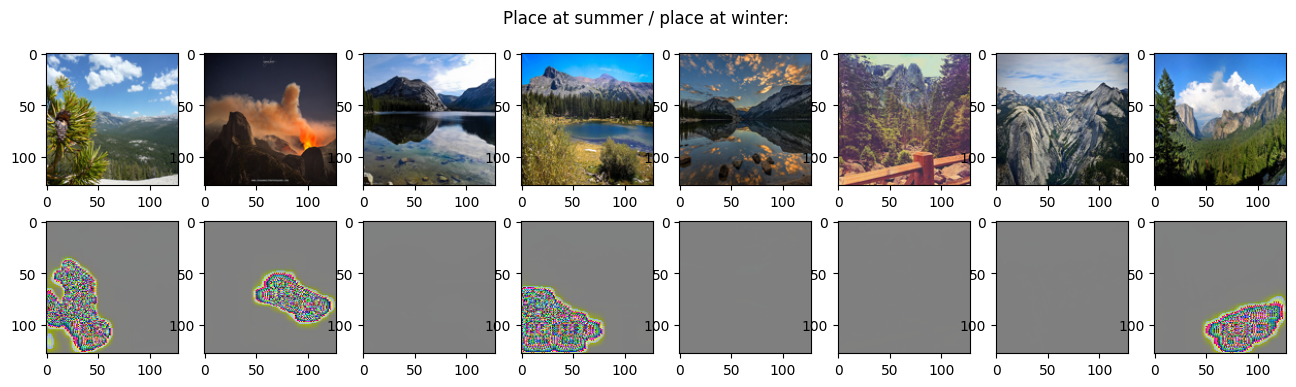

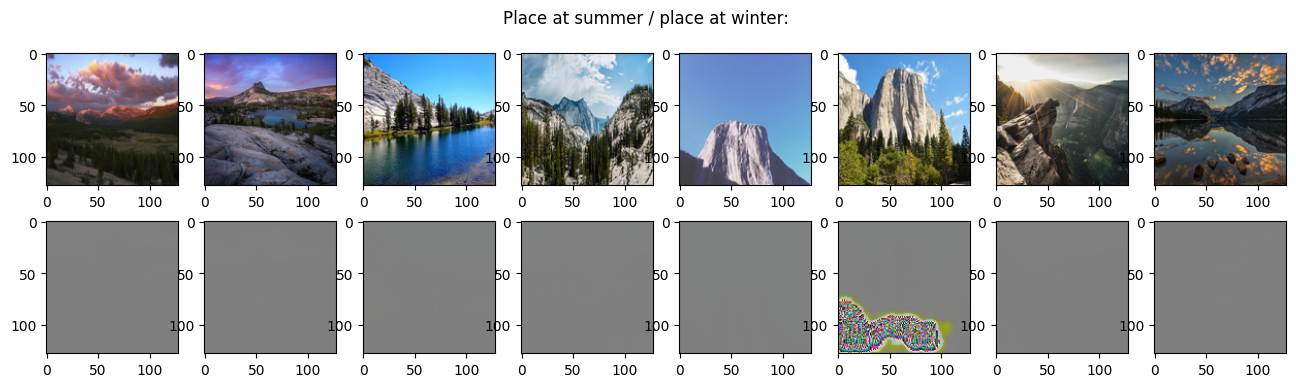

In [76]:
# Initialize classes
psi_theta = ConvICNN()
psi_omega = ConvICNN()
loss_c = W2GNLoss(psi_theta, psi_omega, lambda_cycle=35000.0, compute_extra_reg=True)
trainer = W2GNTrainer(loss_c, lr=1e-4)

# Training loop
epochs = 30

for epoch in range(epochs):
    A_iter = iter(dataloaderA)
    B_iter = iter(dataloaderB)

    for i in tqdm(range(len(dataloaderA)), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        X = next(A_iter)[0].permute(0, 3, 1, 2)
        Y = next(B_iter)[0].permute(0, 3, 1, 2)
        #print(X.shape, Y.shape)
        # Training step
        losses = trainer.step(X.to(trainer.loss_c.theta_device()), Y.to(trainer.loss_c.omega_device()))

        loss_R = f"{losses['loss_R']:.4f}" if losses.get('loss_R') is not None else '?'
        print(f"\nEpoch {epoch}: " +
            f"Corr={losses['loss_corr']:.4f}, " +
            f"Cycle={losses['loss_cycle']:.4f}, " +
            f"Reg={loss_R}, " +
            f"Total={losses['loss_total']:.4f}")

    Val_iter = iter(dataVal)
    X_test = next(Val_iter)[0].permute(0, 3, 1, 2).to(trainer.loss_c.theta_device())
    Y_generated = trainer.generate(X_test).detach().cpu()

    cols = 8

    # Visualize
    fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(16, 4))
    fig.suptitle('Place at summer / place at winter:')

    denorm = lambda x: (x + 1.0) * 128.0

    for i in range(cols):
        X_img = np.asarray(denorm(X_test.cpu().permute(0, 2, 3, 1)[i]), dtype=np.uint8)
        _ = axes[0][i].imshow(X_img)

        Y_img = np.asarray(denorm(Y_generated.cpu().permute(0, 2, 3, 1)[i]), dtype=np.uint8)
        _ = axes[1][i].imshow(Y_img)

    #plt.tight_layout()
    fig.show()

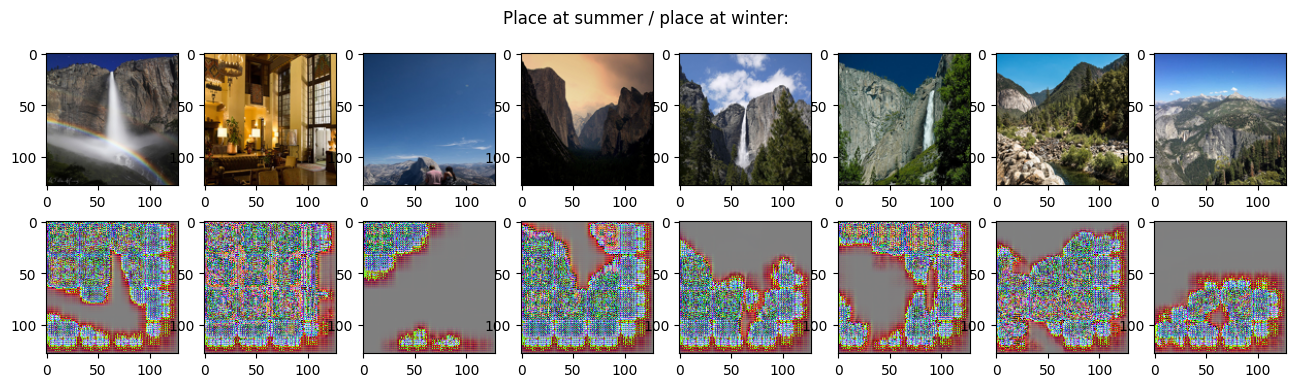

In [72]:
Val_iter = iter(dataVal)
X_test = next(Val_iter)[0].permute(0, 3, 1, 2).to(trainer.loss_c.theta_device())
Y_generated = trainer.generate(X_test).detach().cpu()

cols = 8

# Visualize
fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(16, 4))
fig.suptitle('Place at summer / place at winter:')

denorm = lambda x: (x + 1.0) * 128.0

for i in range(cols):
    X_img = np.asarray(denorm(X_test.cpu().permute(0, 2, 3, 1)[i]), dtype=np.uint8)
    _ = axes[0][i].imshow(X_img)

    Y_img = np.asarray(denorm(Y_generated.cpu().permute(0, 2, 3, 1)[i]), dtype=np.uint8)
    _ = axes[1][i].imshow(Y_img)

#plt.tight_layout()
fig.show()